In [3]:
from qiskit_metal import draw, Dict
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
import qiskit_metal as metal

In [2]:
# -*- coding: utf-8 -*-

# This code is part of Qiskit.
#
# (C) Copyright IBM 2017, 2021.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
"""Concentric Transmon.
"""

from math import sin, cos, asin, atan
import numpy as np
from qiskit_metal import draw, Dict
from qiskit_metal.qlibrary.core import BaseQubit


class Transmon_SingleCircle(BaseQubit):
    """The base `TrasmonConcentric` class .

    Inherits `BaseQubit` class.

    Metal transmon object consisting of a circle surrounding by a concentric
    ring. There are two Josephson Junction connecting the circle to the ring;
    one at the south end and one at the north end. There is a readout resonator.

    .. image::
        transmon_concentric.png

    .. meta::
        Transmon Concentric

    BaseQubit Default Options:
        * connection_pads: empty Dict -- the dictionary which contains all active
          connection lines for the qubit.
        * _default_connection_pads: empty Dict -- the default values for the
          (if any) connection lines of the qubit.

    Default Options:
        * width: '1000um' -- Width of transmon pocket
        * height: '1000um' -- Height of transmon pocket
        * rad_o: '170um' -- Outer radius
        * rad_i: '115um' -- Inner radius
        * gap: '35um' -- Radius of gap between two pads
        * jj_w: '10um' -- Josephson Junction width
        * res_s: '100um' -- Space between top electrode and readout resonator
        * res_ext: '100um' -- Extension of readout resonator in x-direction
          beyond midpoint of transmon
        * fbl_rad: '100um' -- Radius of the flux bias line loop
        * fbl_sp: '100um' -- Spacing between metal pad and flux bias loop
        * fbl_gap: '80um' -- Space between parallel lines of the flux bias loop
        * fbl_ext: '300um' -- Run length of flux bias line between circular
          loop and edge of pocket
        * pocket_w: '1500um' -- Transmon pocket width
        * pocket_h: '1000um' -- Transmon pocket height
        * cpw_width: '10.0um' -- Width of the readout resonator and flux bias line
    """

    # default drawing options
    default_options = Dict(
        rad_i='115um',  # radius of metal pad
        gap='35um',  # radius of gap between metal pad and pocket
        jj_w='10um',  # Josephson Junction width
        res_s='100um',  # space between top electrode and readout resonator
        res_ext=
        '100um',  # extension of readout resonator in x-direction beyond midpoint of transmon
        fbl_rad='100um',  # radius of the flux bias line loop
        fbl_sp='100um',  # spacing between metal pad and flux bias loop
        fbl_gap='80um',  # space between parallel lines of the flux bias loop
        fbl_ext=
        '300um',  # run length of flux bias line between circular loop and edge of pocket
        pocket_w='1500um',  # transmon pocket width
        pocket_h='1000um',  # transmon pocket height
        cpw_width='10.0um',  # width of the readout resonator and flux bias line
        inductor_width='5.0um'  # width of the Josephson Junctions
    )
    """Default drawing options"""

    TOOLTIP = """The base `TrasmonConcentric` class."""

    def make(self):
        """Convert self.options into QGeometry."""

        p = self.parse_options()  # Parse the string options into numbers

        # draw the concentric pad regions
        outer_pad = draw.Point(0, 0).buffer(p.rad_o)
        space = draw.Point(0, 0).buffer((p.gap + p.rad_i))
        outer_pad = draw.subtract(outer_pad, space)
        inner_pad = draw.Point(0, 0).buffer(p.rad_i)
        #gap = draw.subtract(space, inner_pad)
        #pads = draw.union(outer_pad, inner_pad)

        # draw the bottom Josephson Junction
        jj_b = draw.LineString([(0.0, -1.0 * p.rad_i),
                                (0.0, -1.0 * p.rad_i - 1.0 * p.gap)])

        # draw the readout resonator
        qp1a = (-0.5 * p.pocket_w, p.rad_o + p.res_s
               )  # the first (x,y) coordinate is qpin #1
        qp1b = (p.res_ext, p.rad_o + p.res_s
               )  # the second (x,y) coordinate is qpin #1
        rr = draw.LineString([qp1a, qp1b])

        # draw the flux bias line
        a = (0.5 * p.pocket_w, -0.5 * p.fbl_gap)
        b = (0.5 * p.pocket_w - p.fbl_ext, -0.5 * p.fbl_gap)
        c = (p.rad_o + p.fbl_sp + p.fbl_rad, -1.0 * p.fbl_rad)
        d = (p.rad_o + p.fbl_sp + 0.2929 * p.fbl_rad, 0.0 - 0.7071 * p.fbl_rad)
        e = (p.rad_o + p.fbl_sp, 0.0)
        f = (p.rad_o + p.fbl_sp + 0.2929 * p.fbl_rad, 0.0 + 0.7071 * p.fbl_rad)
        g = (p.rad_o + p.fbl_sp + p.fbl_rad, p.fbl_rad)
        h = (0.5 * p.pocket_w - p.fbl_ext, 0.5 * p.fbl_gap)
        i = (0.5 * p.pocket_w, 0.5 * p.fbl_gap)
        fbl = draw.LineString([a, b, c, d, e, f, g, h, i])

        # draw the transmon pocket bounding box
        pocket = draw.Point(0,0).buffer(p.rad_p)

        # Translate and rotate all shapes
        objects = [outer_pad, inner_pad, jj_t, jj_b, pocket, rr, fbl]
        objects = draw.rotate(objects, p.orientation, origin=(0, 0))
        objects = draw.translate(objects, xoff=p.pos_x, yoff=p.pos_y)
        [outer_pad, inner_pad, jj_t, jj_b, pocket, rr, fbl] = objects

        # define a function that both rotates and translates the qpin coordinates
        def qpin_rotate_translate(x):
            y = list(x)
            z = [0.0, 0.0]
            z[0] = y[0] * cos(p.orientation * 3.14159 / 180) - y[1] * sin(
                p.orientation * 3.14159 / 180)
            z[1] = y[0] * sin(p.orientation * 3.14159 / 180) + y[1] * cos(
                p.orientation * 3.14159 / 180)
            z[0] = z[0] + p.pos_x
            z[1] = z[1] + p.pos_y
            x = (z[0], z[1])
            return x

        # rotate and translate the qpin coordinates
        qp1a = qpin_rotate_translate(qp1a)
        qp1b = qpin_rotate_translate(qp1b)
        a = qpin_rotate_translate(a)
        b = qpin_rotate_translate(b)
        h = qpin_rotate_translate(h)
        i = qpin_rotate_translate(i)

        ##############################################################

        # Use the geometry to create Metal QGeometry
        geom_rr = {'path1': rr}
        geom_fbl = {'path2': fbl}
        geom_outer = {'poly1': outer_pad}
        geom_inner = {'poly2': inner_pad}
        geom_jjt = {'poly4': jj_t}
        geom_jjb = {'poly5': jj_b}
        geom_pocket = {'poly6': pocket}

        self.add_qgeometry('path',
                           geom_rr,
                           layer=1,
                           subtract=False,
                           width=p.cpw_width)
        self.add_qgeometry('path',
                           geom_fbl,
                           layer=1,
                           subtract=False,
                           width=p.cpw_width)
        self.add_qgeometry('poly', geom_outer, layer=1, subtract=False)
        self.add_qgeometry('poly', geom_inner, layer=1, subtract=False)
        self.add_qgeometry('junction',
                           geom_jjt,
                           layer=1,
                           subtract=False,
                           width=p.inductor_width)
        self.add_qgeometry('junction',
                           geom_jjb,
                           layer=1,
                           subtract=False,
                           width=p.inductor_width)
        self.add_qgeometry('poly', geom_pocket, layer=1, subtract=True)

        ###########################################################################

        # Add Qpin connections
        self.add_pin('pin1',
                     points=np.array([qp1b, qp1a]),
                     width=0.01,
                     input_as_norm=True)
        self.add_pin('pin2',
                     points=np.array([b, a]),
                     width=0.01,
                     input_as_norm=True)
        self.add_pin('pin3',
                     points=np.array([h, i]),
                     width=0.01,
                     input_as_norm=True)


In [3]:
design = metal.designs.DesignPlanar()
design.overwrite_enabled = True
gui = metal.MetalGUI(design)
my_transmon_cl = TransmonPocketCS(design,'my_transmon_cl',options=dict( jj_length = '50um',pad_pocket_distance_top = '70um',connection_pads=dict(a=dict(pad_gap = '10um'),b=dict(loc_W=-1,pad_gap = '10um'))))
gui.rebuild()

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)

  arr = construct_1d_object_array_from_listlike(values)



In [9]:
from math import sin,cos,tan, pi

rad_i = 10
gap = 1
pad_gap = 0.5
pad_length = 1
pad_width = 1

In [10]:
out_circle = draw.Point(0,0).buffer(rad_i-gap+pad_gap+pad_width)
in_circle = draw.Point(0,0).buffer(rad_i-gap+pad_gap)
ring = draw.subtract(out_circle,in_circle)

square = draw.rectangle(rad_i,rad_i)

draw.LineString([(0,0),()])

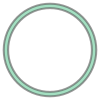

In [11]:
ring

In [9]:
from math import pi

3.141592653589793